In [9]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [10]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms


from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, getTotalLength, mergeSublistsWithSharedItems, initDataset, minimizeProduct
from utils.load import getSamples, getTopofeature, extractWeights
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

In [11]:
trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('../data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
colors = ['r', 'g', 'b', 'y', 'p']


Files already downloaded and verified
cuda


In [12]:

# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_normal_save/"
global_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/fed/"

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
gmodelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
round_set.sort(reverse=True)
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

for dirpath, dirnames, filenames in os.walk(global_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        gmodelpth_set.append(os.path.join(dirpath, filename).replace("\\","/")) if "model" in filename else None

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))
print(len(gmodelpth_set))


modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
weight_keys_resnet = ["conv1.weight", "layer1.0.conv1.weight", "layer1.0.conv2.weight", "layer1.1.conv1.weight", "layer1.1.conv2.weight", "layer1.2.conv1.weight", "layer1.2.conv2.weight", "layer2.0.conv1.weight", "layer2.0.conv2.weight",
 "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer2.2.conv1.weight", "layer2.2.conv2.weight", "layer3.0.conv1.weight", "layer3.0.conv2.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight", "layer3.2.conv1.weight", "layer3.2.conv2.weight"]

if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 16
    weight_keys = weight_keys_resnet
else:
    assert 0==1


rounds [36, 34, 32, 30, 28, 26, 24, 22] 8
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640
16


In [22]:
now = datetime.now()
file_path = "/mnt/sda3/docker_space/Code/PHTDA-Net/data/corrset_temp_v3_5_2024-01-10-18-42-06.txt"


corr_set_recovered = []
normal_nums = int(client_max)
attack_nums = int(client_max/5)
total_nums = normal_nums+attack_nums

total_rounds = len(round_set)
loaded_data = np.loadtxt(file_path)
corr_matrices = loaded_data.reshape(1, total_nums, total_nums, 1)

for idx, matrix in enumerate(corr_matrices):
    round_number = idx  # or fetch from a saved round number list if available
    corr_set_recovered.append([round_number, matrix])

corr_set = corr_set_recovered


In [23]:
from sklearn.cluster import KMeans
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_number, data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    # sns.heatmap(1-data)
    # plt.show()

    k = 2
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data)
    labels = kmeans.labels_
    
    print("Cluster assignments:", labels)



0 (36, 36)
Cluster assignments: [1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]


In [24]:
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps, grouping

0 (36, 36)


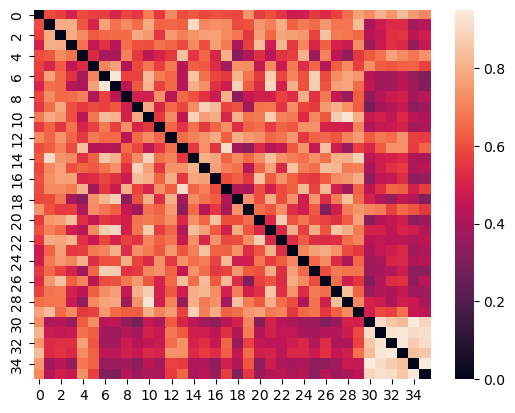

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


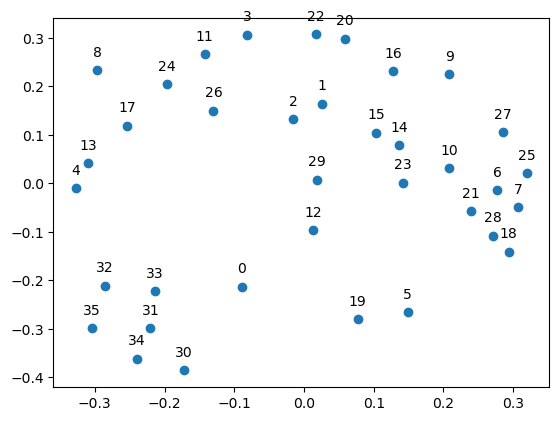

d 0 0 0.0 inf []
d 0 1 0.0 0.26260137281220186 [[11, 25]]
d 0 2 0.0 0.24918948592220613 [[12, 19]]
d 0 3 0.0 0.23400023070852538 [[5, 7]]
d 0 4 0.0 0.22699510148850643 [[0, 29]]
d 0 5 0.0 0.19712993401191958 [[12, 18]]
d 0 6 0.0 0.19493219069102996 [[8, 17]]
d 0 7 0.0 0.18342646371889493 [[15, 27]]
d 0 8 0.0 0.1787035312164108 [[17, 24]]
d 0 9 0.0 0.17103530426559943 [[9, 16]]
d 0 10 0.0 0.16767997109100485 [[0, 33]]
d 0 11 0.0 0.16560530384196204 [[15, 26]]
d 0 12 0.0 0.1638228615892653 [[3, 20]]
d 0 13 0.0 0.1612036323884649 [[13, 26]]
d 0 14 0.0 0.1608989346347932 [[4, 13]]
d 0 15 0.0 0.15760183105408887 [[2, 26]]
d 0 16 0.0 0.1529742219926009 [[16, 20]]
d 0 17 0.0 0.15157632838595891 [[15, 23]]
d 0 18 0.0 0.12888793054680758 [[10, 21]]
d 0 19 0.0 0.12588243480607753 [[20, 22]]
d 0 20 0.0 0.12574205315499576 [[10, 27]]
d 0 21 0.0 0.12284334631370086 [[6, 25]]
d 0 22 0.0 0.12261556489411918 [[7, 18]]
d 0 23 0.0 0.11808974342896594 [[14, 29]]
d 0 24 0.0 0.11593949234092593 [[9, 15]]
d

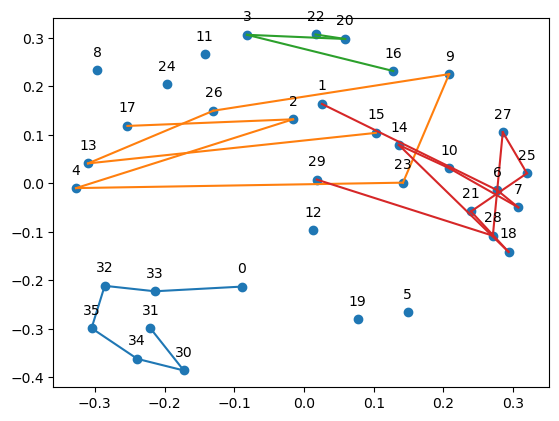

persistence =0.1787035312164108, finding: [9, 16]
 [[2, 3, 4, 9, 13, 15, 16, 17, 20, 22, 23, 26], [0, 33, 32, 35, 34, 30, 31], [1, 6, 7, 10, 14, 18, 21, 25, 27, 28, 29]]
merging
[[3, 16, 20, 22], [2, 4, 9, 13, 15, 17, 23, 26]]
[[1, 0], [2, 0]]
[0, 1, 2]
merging with pbow_d:  3.1622776601683795 7.416198487095663
pbow:
[array([8., 1., 0., 2., 0.]), array([1., 0., 4., 0., 1.]), array([0., 2., 1., 6., 1.])]
[[0.         8.42614977 9.11043358]
 [8.42614977 0.         7.07106781]
 [9.11043358 7.07106781 0.        ]]
score x0.5: [0.0] [0.8571428571428571] [0.0] 
total score : 0.9722222222222222

[[2, 3, 4, 9, 13, 15, 16, 17, 20, 22, 23, 26], [0, 33, 32, 35, 34, 30, 31], [1, 6, 7, 10, 14, 18, 21, 25, 27, 28, 29]]


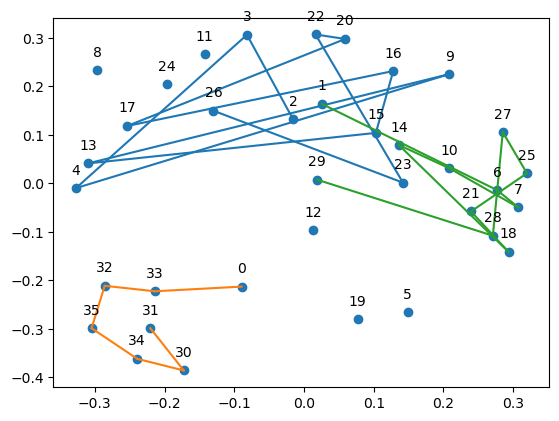

persistence =0.18342646371889493, finding: [17, 24]
 [[2, 3, 4, 9, 13, 15, 16, 17, 20, 22, 23, 24, 26], [0, 33, 32, 35, 34, 30, 31], [1, 6, 7, 10, 14, 18, 21, 25, 27, 28, 29]]
merging
[[24]]
[[0, 0]]
pbow:
[array([0., 4., 2., 1., 5.]), array([5., 1., 0., 0., 0.]), array([2., 0., 6., 2., 0.])]
[[0.         8.         7.87400787]
 [8.         0.         7.07106781]
 [7.87400787 7.07106781 0.        ]]
score x0.5166666666666667: [0.0] [0.8571428571428571] [0.0] 
total score : 0.9722222222222222

[[2, 3, 4, 9, 13, 15, 16, 17, 20, 22, 23, 24, 26], [0, 33, 32, 35, 34, 30, 31], [1, 6, 7, 10, 14, 18, 21, 25, 27, 28, 29]]


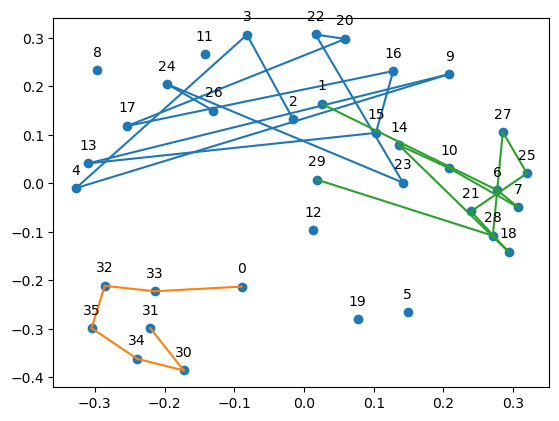

persistence =0.19493219069102996, finding: [15, 27]
 [[1, 2, 3, 4, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [0, 33, 32, 35, 34, 30, 31]]
merging
[[1, 6, 7, 10, 14, 18, 21, 25, 27, 28, 29], [2, 3, 4, 9, 13, 15, 16, 17, 20, 22, 23, 24, 26]]
[[0, 0], [2, 0]]
[0, 2]
merging with pbow_d:  7.874007874011811 8.0
pbow:
[array([2., 7., 8., 3., 3.]), array([5., 1., 0., 0., 0.])]
[[ 0.         11.26942767]
 [11.26942767  0.        ]]
score x0.5166666666666667: [0.0] [0.8571428571428571] 
total score : 0.9722222222222222

[[1, 2, 3, 4, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [0, 33, 32, 35, 34, 30, 31]]


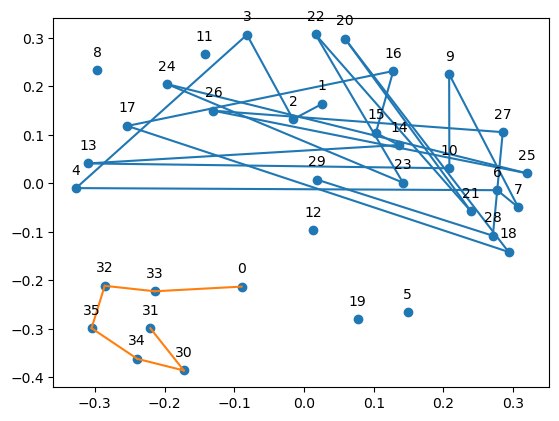

persistence =0.19712993401191958, finding: [8, 17]
 [[1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [0, 33, 32, 35, 34, 30, 31]]
merging
[[8]]
[[0, 0]]
pbow:
[array([8., 8., 2., 3., 3.]), array([0., 1., 5., 0., 0.])]
[[ 0.         11.83215957]
 [11.83215957  0.        ]]
score x0.5333333333333333: [0.0] [0.8571428571428571] 
total score : 0.9722222222222222

[[1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [0, 33, 32, 35, 34, 30, 31]]


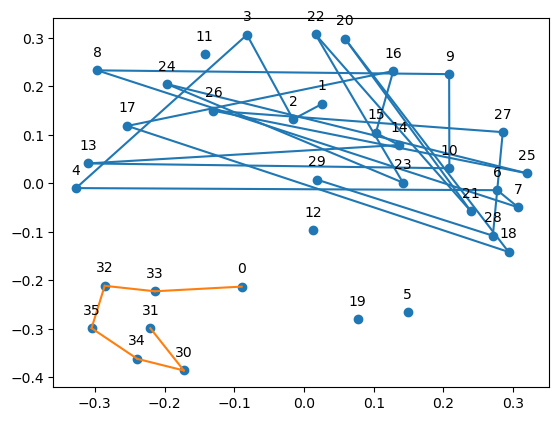

persistence =0.22699510148850643, finding: [12, 18]
 [[1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [0, 33, 32, 35, 34, 30, 31]]
merging
[[12]]
[[0, 0]]
pbow:
[array([8., 2., 8., 4., 3.]), array([1., 5., 0., 0., 0.])]
[[ 0.         12.12435565]
 [12.12435565  0.        ]]
score x0.55: [0.0] [0.8571428571428571] 
total score : 0.9722222222222222

[[1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [0, 33, 32, 35, 34, 30, 31]]


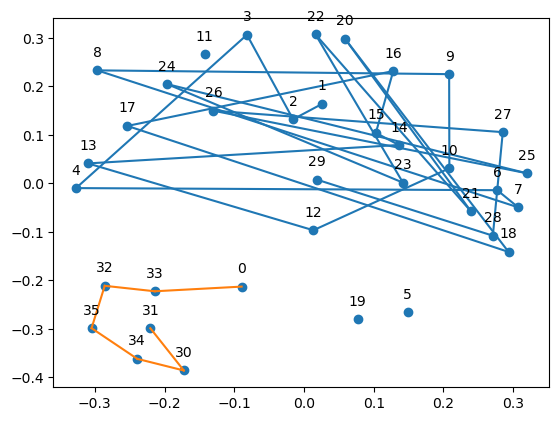

persistence =0.23400023070852538, finding: [0, 29]
 [[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[0, 30, 31, 32, 33, 34, 35], [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  12.12435565298214 12.12435565298214
score x0.55: [0.18181818181818182] 
total score : 0.8333333333333334

persistence =0.24918948592220613, finding: [5, 7]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[5]]
[[0, 0]]
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.26260137281220186, finding: [12, 19]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[19]]
[[0, 0]]
score x0.5833333333333334: [0.1714285

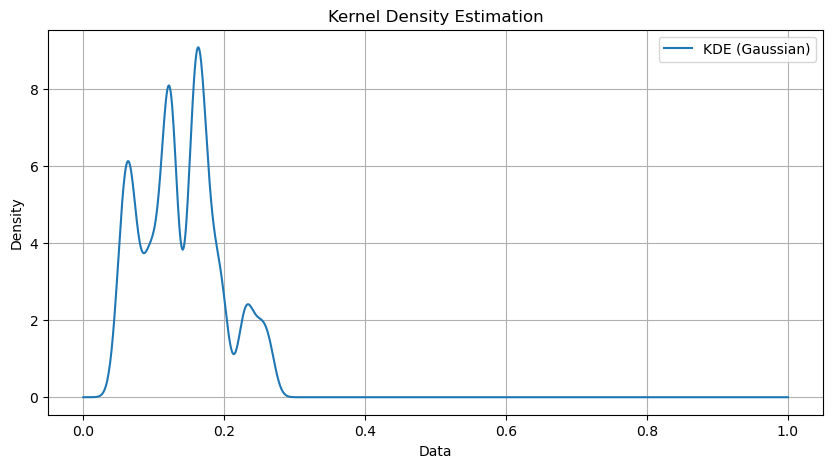

In [25]:
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_number, data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    sns.heatmap(1-data)
    plt.show()

    # Apply Multidimensional Scaling
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    mds_results = mds.fit_transform(data)

    # Plot the points
    plt.scatter(mds_results[:, 0], mds_results[:, 1])

    for i, points in enumerate(mds_results):
        plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()

    dv_seq = grouping(data, total_nums, normal_nums, mds_results)

    
    X = np.array([x for x in dv_seq if x != float('Inf')])
    X = X.reshape(-1, 1)

    # 初始化KDE模型
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

    # 进行密度估计
    X_sample = np.linspace(0, 1, 1000).reshape(-1, 1)
    log_dens = kde.score_samples(X_sample)

    plt.figure(figsize=(10, 5))
    plt.plot(X_sample, np.exp(log_dens), label='KDE (Gaussian)')
    plt.title('Kernel Density Estimation')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plt.scatter(mds_results[:, 0], mds_results[:, 1])
    # for i, points in enumerate(mds_results):
    #     plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    # plt.show()
